In [3]:

!pip3 install ultralytics
!pip3 install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

##  Microsoft TrOCR Model Comparison

| Feature                          | TrOCR Small                  | TrOCR Base                  | TrOCR Large                  |
|----------------------------------|------------------------------|-----------------------------|------------------------------|
| **Model Size (parameters)**     | ~55M                         | ~180M                       | ~400M                        |
| **Inference Speed**             | 🚀 Fast                      | ⚖️ Medium                   | 🐢 Best                    |
| **Example Dataset Support**     | IAM, FUNSD, IIIT5K           | IAM, FUNSD, IIIT5K          | IAM, FUNSD, IIIT5K           |


In [ ]:
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from datetime import datetime
import re
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from datetime import datetime
import re
import locale

# Set French locale for date formatting (adjust if needed)

# Function to clean and format date
def clean_and_format_date(raw_date: str) -> str:
    cleaned = raw_date.replace(" ", "")
    try:
        parsed_date = datetime.strptime(cleaned, "%d%m%Y")
        month_map = {
            1: "Janv", 2: "Févr", 3: "Mars", 4: "Avr", 5: "Mai", 6: "Juin",
            7: "Juil", 8: "Août", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Déc"
        }
        day = parsed_date.day
        month = month_map[parsed_date.month]
        year = parsed_date.year
        return f"{day:02d} {month} {year}"
    except Exception:
        return re.sub(r"(\d{2})(\d{2})(\d{4})", r"\1/\2/\3", cleaned)

yolo_model = YOLO("best.pt")

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-stage1")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-stage1")

image_path = "output.jpg"

results = yolo_model(image_path)[0]

label_map = results.names

image = Image.open(image_path).convert("RGB")

structured_data = {}
for box in results.boxes:
    cls_id = int(box.cls[0].item())
    label = label_map[cls_id].lower()

    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cropped_img = image.crop((x1, y1, x2, y2))

    pixel_values = processor(images=cropped_img, return_tensors="pt").pixel_values
    generated_ids = trocr_model.generate(pixel_values)
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # 📌 Handle fields based on label
    if label == "signature":
        structured_data["signature"] = bool(predicted_text)
    elif label == "date":
        structured_data["date"] = clean_and_format_date(predicted_text)
    elif label == "amount_in_numbers":
        cleaned = predicted_text.replace(" ", "")
        cleaned = re.sub(r"1-$", "", cleaned)
        structured_data["amount_in_numbers"] = cleaned
    else:
        structured_data[label] = predicted_text


for box in results.boxes:
    cls_id = int(box.cls[0].item())
    label = label_map[cls_id].lower()

    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cropped_img = image.crop((x1, y1, x2, y2))

    pixel_values = processor(images=cropped_img, return_tensors="pt").pixel_values
    generated_ids = trocr_model.generate(pixel_values)
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # 📌 Handle fields based on label
    if label == "signature":
        structured_data["signature"] = bool(predicted_text)
    elif label == "date":
        structured_data["date"] = clean_and_format_date(predicted_text)
    elif label == "amount_in_numbers":
        cleaned = predicted_text.replace(" ", "")
        cleaned = re.sub(r"1-$", "", cleaned)
        structured_data["amount_in_numbers"] = cleaned
    else:
        structured_data[label] = predicted_text
# 8️⃣ Print final structured result
print("\n📦 Structured Output:")
for key, value in structured_data.items():
    print(f"{key}: {value}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_head

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


image 1/1 /content/output.jpg: 320x640 1 payee, 1 amount_in_words, 1 amount_in_numbers, 1 date, 1 bank_name, 1 signature, 103.0ms
Speed: 12.0ms preprocess, 103.0ms inference, 377.7ms postprocess per image at shape (1, 3, 320, 640)

📦 Structured Output:
signature: True
bank_name: AXIS BANK
amount_in_words: Seven lasts sixty seven thousand
amount_in_numbers: 767,000
date: 19 Janv 2016
payee: B. AmuLxA Prased


In [ ]:
# 8️⃣ Print final structured result
print("\n📦 Structured Output:")
for key, value in structured_data.items():
    print(f"{key}: {value}")


📦 Structured Output:
signature: True
bank_name: AXIS BANK
amount_in_words: Seven lasts sixty seven thousand
amount_in_numbers: 767,000
date: 19 Janv 2016
payee: B. AmuLxA Prased


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_head


📄 Evaluating: check1.jpg

image 1/1 /content/output.jpg: 320x640 1 payee, 1 amount_in_words, 1 amount_in_numbers, 1 date, 1 bank_name, 1 signature, 10.1ms
Speed: 2.0ms preprocess, 10.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
  - Field: date
    ➤ GT   : 19 Janv 2016
    ➤ Pred : 19 Janv 2016
    ✔ Match: True
    🔁 Similarity: 1.00
  - Field: amount_in_numbers
    ➤ GT   : 767,000
    ➤ Pred : 767,000
    ✔ Match: True
    🔁 Similarity: 1.00
  - Field: amount_in_words
    ➤ GT   : Seven backs sixty seven thousand
    ➤ Pred : Seven lasts sixty seven thousand
    ✔ Match: False
    🔁 Similarity: 0.91
  - Field: signature
    ➤ GT   : True
    ➤ Pred : True
    ✔ Match: True
    🔁 Similarity: 1.00
  - Field: payee
    ➤ GT   : B. AmULYA Prasad
    ➤ Pred : B. AmuLxA Prased
    ✔ Match: False
    🔁 Similarity: 0.81

📊 Final Evaluation Summary:
Metric                              | Value
--------------------------------------------------
Exact Match Accuracy    

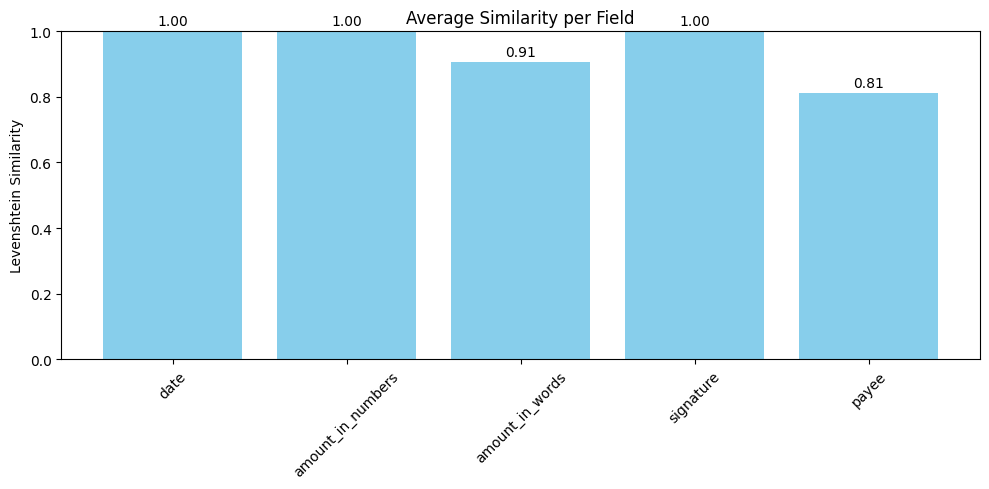

In [10]:
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from datetime import datetime
import re
import os
from jiwer import wer, cer
import json
import numpy as np
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

# ---------------------- Utility Functions ----------------------

def clean_and_format_date(raw_date: str) -> str:
    cleaned = raw_date.replace(" ", "")
    try:
        parsed_date = datetime.strptime(cleaned, "%d%m%Y")
        month_map = {
            1: "Janv", 2: "Févr", 3: "Mars", 4: "Avr", 5: "Mai", 6: "Juin",
            7: "Juil", 8: "Août", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Déc"
        }
        return f"{parsed_date.day:02d} {month_map[parsed_date.month]} {parsed_date.year}"
    except Exception:
        return re.sub(r"(\d{2})(\d{2})(\d{4})", r"\1/\2/\3", cleaned)

def levenshtein_similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

def exact_match(pred, true):
    return str(pred).strip().lower() == str(true).strip().lower()

# ---------------------- Load Models ----------------------

yolo_model = YOLO("best.pt")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-stage1")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-stage1")

# ---------------------- Ground Truth Format ----------------------

ground_truths = {
    "check1.jpg": {
        "date": "19 Janv 2016",
        "amount_in_numbers": "767,000",
        "amount_in_words": "Seven backs sixty seven thousand",
        "signature": True,
        "payee": "B. AmULYA Prasad"
    }
}

# ---------------------- Evaluation Tracking ----------------------

total_fields = 0
correct_fields = 0
similarity_scores = []
all_refs = []
all_preds = []
field_similarities = {}

# ---------------------- Evaluation Loop ----------------------

for image_filename, gt in ground_truths.items():
    print(f"\n📄 Evaluating: {image_filename}")
    image_path = "output.jpg"  # Adjust path as needed
    image = Image.open(image_path).convert("RGB")

    results = yolo_model(image_path)[0]
    label_map = results.names

    structured_data = {}

    for box in results.boxes:
        cls_id = int(box.cls[0].item())
        label = label_map[cls_id].lower()

        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cropped_img = image.crop((x1, y1, x2, y2))

        pixel_values = processor(images=cropped_img, return_tensors="pt").pixel_values
        generated_ids = trocr_model.generate(pixel_values)
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

        if label == "signature":
            structured_data["signature"] = bool(predicted_text)
        elif label == "date":
            structured_data["date"] = clean_and_format_date(predicted_text)
        elif label == "amount_in_numbers":
            cleaned = predicted_text.replace(" ", "")
            cleaned = re.sub(r"1-$", "", cleaned)
            structured_data["amount_in_numbers"] = cleaned
        elif label == "amount_in_words":
            structured_data["amount_in_words"] = predicted_text
        else:
            structured_data[label] = predicted_text

    # 🔍 Evaluate extracted fields
    for field, true_value in gt.items():
        pred_value = structured_data.get(field, "")
        total_fields += 1

        if isinstance(true_value, bool):
            match = exact_match(pred_value, true_value)
            similarity = 1.0 if match else 0.0
        else:
            match = exact_match(pred_value, true_value)
            similarity = levenshtein_similarity(pred_value, true_value)
            all_refs.append(str(true_value))
            all_preds.append(str(pred_value))

        if match:
            correct_fields += 1

        similarity_scores.append(similarity)
        field_similarities.setdefault(field, []).append(similarity)

        print(f"  - Field: {field}")
        print(f"    ➤ GT   : {true_value}")
        print(f"    ➤ Pred : {pred_value}")
        print(f"    ✔ Match: {match}")
        print(f"    🔁 Similarity: {similarity:.2f}")

# ---------------------- Metrics Summary ----------------------

accuracy = correct_fields / total_fields if total_fields else 0
avg_similarity = np.mean(similarity_scores) if similarity_scores else 0
overall_wer = wer(all_refs, all_preds)
overall_cer = cer(all_refs, all_preds)

print("\n📊 Final Evaluation Summary:")
print(f"{'Metric':<35} | {'Value'}")
print("-" * 50)
print(f"{'Exact Match Accuracy':<35} | {accuracy:.2%}")
print(f"{'Avg Levenshtein Similarity':<35} | {avg_similarity:.2%}")
print(f"{'Word Error Rate (WER)':<35} | {overall_wer:.2%}")
print(f"{'Character Error Rate (CER)':<35} | {overall_cer:.2%}")

# ---------------------- Visual Display ----------------------

field_names = list(ground_truths[list(ground_truths.keys())[0]].keys())
avg_similarities = [np.mean(field_similarities.get(field, [0])) for field in field_names]

plt.figure(figsize=(10, 5))
bars = plt.bar(field_names, avg_similarities, color='skyblue')
plt.ylim(0, 1)
plt.title("Average Similarity per Field")
plt.ylabel("Levenshtein Similarity")
plt.xticks(rotation=45)

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()



In [5]:
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from datetime import datetime
import re
import os
import json
!pip3 install word2number
from word2number import w2n

  Preparing metadata (setup.py) ... done
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5568 sha256=b289c2a94f75dc94415999ca01d265fbcc3255ceb8b2f8e4ff3983bf7c0f4e32
  Stored in directory: /root/.cache/pip/wheels/cd/ef/ae/073b491b14d25e2efafcffca9e16b2ee6d114ec5c643ba4f06
Successfully built word2number


In [6]:
from ultralytics import YOLO
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from datetime import datetime
import re
import os
import json
from word2number import w2n

# ---------- Utility Functions ----------

def clean_and_format_date(raw_date: str) -> str:
    cleaned = raw_date.replace(" ", "")
    try:
        parsed_date = datetime.strptime(cleaned, "%d%m%Y")
        month_map = {
            1: "Janv", 2: "Févr", 3: "Mars", 4: "Avr", 5: "Mai", 6: "Juin",
            7: "Juil", 8: "Août", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Déc"
        }
        return f"{parsed_date.day:02d} {month_map[parsed_date.month]} {parsed_date.year}"
    except Exception:
        return re.sub(r"(\d{2})(\d{2})(\d{4})", r"\1/\2/\3", cleaned)

def normalize_amount(amount: str) -> float:
    if not amount:
        return 0.0
    # Remove spaces, non-numeric characters except for decimal point
    cleaned = re.sub(r"[^\d.]", "", amount)
    cleaned = re.sub(r"1-", "", cleaned)  # Remove '1-' wherever it appears
    try:
        return cleaned
    except:
        return 0.0

def words_to_number(amount_words: str) -> float:
    try:
        return round(w2n.word_to_num(amount_words.lower()), 2)
    except:
        return 0.0

# ---------- Load Models ----------

yolo_model = YOLO("best.pt")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-stage1")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-stage1")

# ---------- Input Directory ----------

image_dir = "."
results_list = []

# ---------- Process Each Image ----------

for image_filename in os.listdir(image_dir):
    if not image_filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    image_path = os.path.join(image_dir, image_filename)
    image = Image.open(image_path).convert("RGB")

    results = yolo_model(image_path)[0]
    label_map = results.names
    structured_data = {
        "image_path": image_path
    }

    for box in results.boxes:
        cls_id = int(box.cls[0].item())
        label = label_map[cls_id].lower()
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cropped_img = image.crop((x1, y1, x2, y2))

        pixel_values = processor(images=cropped_img, return_tensors="pt").pixel_values
        generated_ids = trocr_model.generate(pixel_values)
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

        if label == "signature":
            structured_data["signature"] = bool(predicted_text.strip())
        elif label == "date":
            structured_data["date"] = clean_and_format_date(predicted_text)
        elif label == "amount_in_numbers":
            # Remove spaces, commas and "-1" at the end
            cleaned = predicted_text.replace(" ", "").replace(",", "")
            cleaned = re.sub(r'-\d+$', '', cleaned)
            cleaned = re.sub(r"-1", "", cleaned)  # Remove the ending '-1'
            cleaned = re.sub(r"1-", "", cleaned)  # Remove the ending '-1'

            structured_data["amount_in_numbers"] = cleaned
            print("amount-in-numbers")
            print(structured_data["amount_in_numbers"])
        elif label == "amount_in_words":
            structured_data["amount_in_words"] = predicted_text
        elif label == "payee":
            structured_data["payee"] = predicted_text

    # ---------- Post-processing ----------

    raw_amount = structured_data.get("amount_in_numbers", "0")
    amount_number = normalize_amount(raw_amount)
    amount_words = structured_data.get("amount_in_words", "")
    converted_number = words_to_number(amount_words)
    signature = structured_data.get("signature", False)

    structured_data["converted_number"] = converted_number
    structured_data["status"] = signature and (amount_number == converted_number)

    results_list.append(structured_data)

# ---------- Final Output ----------

print(json.dumps(results_list, indent=4, ensure_ascii=False))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_head

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


image 1/1 /content/output.jpg: 320x640 1 payee, 1 amount_in_words, 1 amount_in_numbers, 1 date, 1 bank_name, 1 signature, 115.7ms
Speed: 19.5ms preprocess, 115.7ms inference, 337.1ms postprocess per image at shape (1, 3, 320, 640)
amount-in-numbers
767000
[
    {
        "image_path": "./output.jpg",
        "signature": true,
        "amount_in_words": "Seven lasts sixty seven thousand",
        "amount_in_numbers": "767000",
        "date": "19 Janv 2016",
        "payee": "B. AmuLxA Prased",
        "converted_number": 427000,
        "status": false
    }
]


## 📊 OCR Evaluation Metrics Table

| **Metric**                    | **Description**                                                                 | **Formula**                                          |
|------------------------------|----------------------------------------------------------------------------------|------------------------------------------------------|
| **Exact Match Accuracy**     | Percentage of fields where prediction matches exactly with the ground truth.    | `Matches / Total fields`                            |
| **Levenshtein Similarity**   | Similarity score between predicted and true strings (normalized edit distance). | `1 - (EditDistance / MaxLength)`                    |
| **WER (Word Error Rate)**    | Measures word-level errors in extracted text.                                   | `WER = (S + D + I) / N` <br> S=sub, D=del, I=ins, N=words in ref |
| **CER (Character Error Rate)**| Measures character-level errors in extracted text.                              | `CER = (S + D + I) / N` <br> (on characters)         |
